In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from torch.nn.parameter import Parameter
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:3


In [2]:
data = scipy.io.loadmat('burgers_shock_10sin.mat')  	# Load data from file

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

label = "QCRE_2D_5_tanhxtanh_NW"
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']   

#usol = usol/1000# solution of 256x100 grid points

X, T = np.meshgrid(x,t)   

In [9]:
np.hstack((X[:,0][:,None], T[:,0][:,None]))

array([[-1.        ,  0.        ],
       [-1.        ,  0.0020202 ],
       [-1.        ,  0.0040404 ],
       [-1.        ,  0.00606061],
       [-1.        ,  0.00808081],
       [-1.        ,  0.01010101],
       [-1.        ,  0.01212121],
       [-1.        ,  0.01414141],
       [-1.        ,  0.01616162],
       [-1.        ,  0.01818182],
       [-1.        ,  0.02020202],
       [-1.        ,  0.02222222],
       [-1.        ,  0.02424242],
       [-1.        ,  0.02626263],
       [-1.        ,  0.02828283],
       [-1.        ,  0.03030303],
       [-1.        ,  0.03232323],
       [-1.        ,  0.03434343],
       [-1.        ,  0.03636364],
       [-1.        ,  0.03838384],
       [-1.        ,  0.04040404],
       [-1.        ,  0.04242424],
       [-1.        ,  0.04444444],
       [-1.        ,  0.04646465],
       [-1.        ,  0.04848485],
       [-1.        ,  0.05050505],
       [-1.        ,  0.05252525],
       [-1.        ,  0.05454545],
       [-1.        ,

In [3]:
def trainingdata(N_u,N_f,seed):

    '''Boundary Conditions'''
    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    np.random.seed(seed)
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train

In [4]:
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_true = usol.flatten('F')[:,None]

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        self.beta = Parameter(0.25*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        self.beta_val = []
        
    'foward pass'
    def forward(self,x):
         if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
         u_b = torch.from_numpy(ub).float().to(device)
         l_b = torch.from_numpy(lb).float().to(device)
                      
         #preprocessing input 
         x = (x - l_b)/(u_b - l_b) #feature scaling
        
         #convert to float
         a = x.float()
                        
         '''     
         Alternatively:
        
         a = self.activation(self.fc1(a))
         a = self.activation(self.fc2(a))
         a = self.activation(self.fc3(a))
         a = self.fc4(a)
         
         '''
        
         for i in range(len(layers)-2):
                z = self.linears[i](a)
                a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
         
         a = self.linears[-1](a)
        
         return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f,f_hat):
        
        nu = 0.01/pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f,f_hat):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f,f_hat)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(X_u_train, u_train, X_f_train,f_hat)
        
        self.train_loss.append(loss.cpu().detach().numpy())
        
        
        u_pred = self.test(X_u_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        
        loss.backward()
        self.iter += 1
     
        return loss        
    'test neural network'
    
    def test(self,xt_test_tensor):
        u_pred = self.forward(X_u_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))


for reps in range(max_reps):
    print(reps)
    N_u = 200 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 
    
    X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,reps*43)
        
    X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
    X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
    u = torch.from_numpy(u_true).float().to(device)
    f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

    X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
    'Convert to tensor and send to GPU'


    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
       
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                                  max_iter = 3000, 
                                  max_eval = None, 
                                  tolerance_grad = -1, 
                                  tolerance_change = -1, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

    start_time = time.time()

    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)
    

mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 28.390257 Test Loss 24.524365234656123
1 Train Loss 27.838833 Test Loss 24.52289657232022
2 Train Loss 26.308802 Test Loss 24.471032347608592
3 Train Loss 26.21892 Test Loss 24.39795519783399
4 Train Loss 25.410006 Test Loss 23.644246198049185
5 Train Loss 25.069773 Test Loss 22.7147787

144 Train Loss 14.166407 Test Loss 11.95177192862225
145 Train Loss 14.160181 Test Loss 11.942066643339947
146 Train Loss 14.157715 Test Loss 11.939937421048239
147 Train Loss 14.154195 Test Loss 11.947688109385757
148 Train Loss 14.152421 Test Loss 11.940695876323046
149 Train Loss 14.147976 Test Loss 11.934624725645365
150 Train Loss 14.11914 Test Loss 11.886290064693076
151 Train Loss 14.099616 Test Loss 11.865557872714176
152 Train Loss 14.085177 Test Loss 11.859625348185059
153 Train Loss 14.075358 Test Loss 11.850659159247641
154 Train Loss 14.065081 Test Loss 11.85654936834872
155 Train Loss 14.049499 Test Loss 11.865385544243297
156 Train Loss 14.039034 Test Loss 11.855189706655738
157 Train Loss 14.031663 Test Loss 11.841519318244588
158 Train Loss 14.027585 Test Loss 11.833768084918466
159 Train Loss 14.026576 Test Loss 11.836116594713282
160 Train Loss 14.024035 Test Loss 11.835917629328662
161 Train Loss 14.007925 Test Loss 11.823134683064058
162 Train Loss 13.993872 Test L

300 Train Loss 13.007143 Test Loss 10.990715041647078
301 Train Loss 13.003444 Test Loss 10.991118842226228
302 Train Loss 12.9958 Test Loss 10.983802129013352
303 Train Loss 12.986787 Test Loss 10.971216425781154
304 Train Loss 12.972189 Test Loss 10.961345839191267
305 Train Loss 12.956332 Test Loss 10.949217141034751
306 Train Loss 12.9449625 Test Loss 10.946607582802457
307 Train Loss 12.941453 Test Loss 10.94317231061645
308 Train Loss 12.9384165 Test Loss 10.942321488167854
309 Train Loss 12.9367485 Test Loss 10.9398525179609
310 Train Loss 12.935683 Test Loss 10.937674896339537
311 Train Loss 12.934379 Test Loss 10.937564043119778
312 Train Loss 12.932182 Test Loss 10.934815068473204
313 Train Loss 12.928512 Test Loss 10.929371061425515
314 Train Loss 12.924051 Test Loss 10.909147049064297
315 Train Loss 12.910519 Test Loss 10.909054831883786
316 Train Loss 12.89359 Test Loss 10.893297686838345
317 Train Loss 12.879066 Test Loss 10.8706377793554
318 Train Loss 12.940767 Test Los

456 Train Loss 12.152025 Test Loss 10.101718070280436
457 Train Loss 12.150999 Test Loss 10.10218754256564
458 Train Loss 12.2372465 Test Loss 10.120305048844498
459 Train Loss 12.15073 Test Loss 10.103353786692429
460 Train Loss 12.149659 Test Loss 10.101738039019576
461 Train Loss 12.148824 Test Loss 10.097884372385975
462 Train Loss 12.1495075 Test Loss 10.093003099139604
463 Train Loss 12.147931 Test Loss 10.095740192826094
464 Train Loss 12.146547 Test Loss 10.097147246541882
465 Train Loss 12.145314 Test Loss 10.09943483711777
466 Train Loss 12.143637 Test Loss 10.09706440378031
467 Train Loss 12.1422825 Test Loss 10.096106020486033
468 Train Loss 12.139427 Test Loss 10.090617357922142
469 Train Loss 12.140342 Test Loss 10.086710895400083
470 Train Loss 12.137196 Test Loss 10.088721693993913
471 Train Loss 12.133603 Test Loss 10.084776514953383
472 Train Loss 12.129874 Test Loss 10.064990701600134
473 Train Loss 12.125317 Test Loss 10.072359965608369
474 Train Loss 12.147983 Test

612 Train Loss 11.766082 Test Loss 9.89416352186999
613 Train Loss 11.76352 Test Loss 9.893987273914512
614 Train Loss 11.766336 Test Loss 9.89368618050123
615 Train Loss 11.762441 Test Loss 9.893795873711673
616 Train Loss 11.7606325 Test Loss 9.889288666756709
617 Train Loss 11.839729 Test Loss 9.897954825958097
618 Train Loss 11.7604685 Test Loss 9.88969418221244
619 Train Loss 11.758952 Test Loss 9.887653588206744
620 Train Loss 11.758087 Test Loss 9.886110782682117
621 Train Loss 11.757768 Test Loss 9.887651606316586
622 Train Loss 11.757512 Test Loss 9.88813316805407
623 Train Loss 11.757344 Test Loss 9.888689061878827
624 Train Loss 11.757375 Test Loss 9.888603715325553
625 Train Loss 11.757245 Test Loss 9.888642889253543
626 Train Loss 11.757005 Test Loss 9.88876167413983
627 Train Loss 11.75676 Test Loss 9.88807358588088
628 Train Loss 11.756199 Test Loss 9.886356114177273
629 Train Loss 11.755666 Test Loss 9.884824414863761
630 Train Loss 11.754956 Test Loss 9.883777925343344

768 Train Loss 11.600964 Test Loss 9.813255510872049
769 Train Loss 11.600067 Test Loss 9.809460736687447
770 Train Loss 11.598964 Test Loss 9.804712272086007
771 Train Loss 11.598324 Test Loss 9.803516635742817
772 Train Loss 11.597854 Test Loss 9.804639726688436
773 Train Loss 11.597139 Test Loss 9.80559517330072
774 Train Loss 11.598902 Test Loss 9.813634840154657
775 Train Loss 11.596699 Test Loss 9.80803652642067
776 Train Loss 11.602973 Test Loss 9.830198203663882
777 Train Loss 11.595713 Test Loss 9.81400712327154
778 Train Loss 11.593597 Test Loss 9.812074142510905
779 Train Loss 11.589872 Test Loss 9.812838477959845
780 Train Loss 11.586966 Test Loss 9.809382278766556
781 Train Loss 11.588918 Test Loss 9.802382820437952
782 Train Loss 11.582345 Test Loss 9.805800710272768
783 Train Loss 11.578335 Test Loss 9.810658131806102
784 Train Loss 11.574189 Test Loss 9.816263411549956
785 Train Loss 11.574616 Test Loss 9.814767069177094
786 Train Loss 11.572982 Test Loss 9.815492480520

925 Train Loss 11.412497 Test Loss 9.742093281587765
926 Train Loss 11.410153 Test Loss 9.743435423625375
927 Train Loss 11.410089 Test Loss 9.738310192288226
928 Train Loss 11.4084635 Test Loss 9.740755945645459
929 Train Loss 11.412455 Test Loss 9.743926796334565
930 Train Loss 11.407117 Test Loss 9.74174690384572
931 Train Loss 11.404041 Test Loss 9.735566941366915
932 Train Loss 11.401448 Test Loss 9.733478525489478
933 Train Loss 11.399484 Test Loss 9.732380122021015
934 Train Loss 11.39714 Test Loss 9.728124007737646
935 Train Loss 11.394794 Test Loss 9.726613167520876
936 Train Loss 11.392118 Test Loss 9.724961911757243
937 Train Loss 11.390857 Test Loss 9.723894677780674
938 Train Loss 11.389114 Test Loss 9.724987744855106
939 Train Loss 11.386501 Test Loss 9.723565433076962
940 Train Loss 11.385202 Test Loss 9.723873757250262
941 Train Loss 11.383327 Test Loss 9.722695857535177
942 Train Loss 11.381906 Test Loss 9.717750728343034
943 Train Loss 11.380524 Test Loss 9.7073000770

1080 Train Loss 10.951582 Test Loss 9.482075079113931
1081 Train Loss 10.946526 Test Loss 9.483202828473337
1082 Train Loss 10.943583 Test Loss 9.48911846355934
1083 Train Loss 10.939517 Test Loss 9.49186018433144
1084 Train Loss 10.942879 Test Loss 9.490423971993728
1085 Train Loss 10.937102 Test Loss 9.491234140186439
1086 Train Loss 10.932574 Test Loss 9.487501639528391
1087 Train Loss 10.927037 Test Loss 9.49350318751917
1088 Train Loss 10.919942 Test Loss 9.491745698795729
1089 Train Loss 10.913895 Test Loss 9.487441017054625
1090 Train Loss 10.912032 Test Loss 9.486116365560562
1091 Train Loss 10.909717 Test Loss 9.486304075134326
1092 Train Loss 10.908158 Test Loss 9.488297530520654
1093 Train Loss 10.9068985 Test Loss 9.489466552152429
1094 Train Loss 10.905229 Test Loss 9.491131626378614
1095 Train Loss 10.902983 Test Loss 9.492571445926496
1096 Train Loss 10.9009905 Test Loss 9.493143671636235
1097 Train Loss 10.898201 Test Loss 9.491283093104693
1098 Train Loss 10.894264 Tes

1236 Train Loss 10.358498 Test Loss 9.225472587174716
1237 Train Loss 10.356133 Test Loss 9.223217061061307
1238 Train Loss 10.353873 Test Loss 9.224401789188658
1239 Train Loss 10.352098 Test Loss 9.22428624874558
1240 Train Loss 10.350659 Test Loss 9.2264874995518
1241 Train Loss 10.349638 Test Loss 9.226106229021307
1242 Train Loss 10.34832 Test Loss 9.22407257990168
1243 Train Loss 10.346712 Test Loss 9.220373863180304
1244 Train Loss 10.34523 Test Loss 9.218294977789215
1245 Train Loss 10.343661 Test Loss 9.21404730703172
1246 Train Loss 10.34249 Test Loss 9.21499180946852
1247 Train Loss 10.341228 Test Loss 9.217269809436038
1248 Train Loss 10.339427 Test Loss 9.222038314897658
1249 Train Loss 10.338452 Test Loss 9.22433815742978
1250 Train Loss 10.337552 Test Loss 9.225238808930747
1251 Train Loss 10.336578 Test Loss 9.224885589145293
1252 Train Loss 10.335423 Test Loss 9.223165757517524
1253 Train Loss 10.333715 Test Loss 9.22132340470475
1254 Train Loss 10.331425 Test Loss 9.2

1392 Train Loss 9.747797 Test Loss 8.804528053741059
1393 Train Loss 9.731474 Test Loss 8.775200687672509
1394 Train Loss 9.720197 Test Loss 8.76220336292743
1395 Train Loss 9.7095585 Test Loss 8.76443016378958
1396 Train Loss 9.70207 Test Loss 8.75861598271038
1397 Train Loss 9.693399 Test Loss 8.750371634784033
1398 Train Loss 9.690643 Test Loss 8.736422759151226
1399 Train Loss 9.685627 Test Loss 8.743824984943629
1400 Train Loss 9.686213 Test Loss 8.746737503963468
1401 Train Loss 9.682552 Test Loss 8.745177078845915
1402 Train Loss 9.67892 Test Loss 8.740071541576743
1403 Train Loss 9.673414 Test Loss 8.721769662856905
1404 Train Loss 9.665843 Test Loss 8.719007278780104
1405 Train Loss 9.659861 Test Loss 8.719985191323962
1406 Train Loss 9.872245 Test Loss 8.703436869238283
1407 Train Loss 9.655711 Test Loss 8.71399156407335
1408 Train Loss 9.648774 Test Loss 8.712585646001303
1409 Train Loss 9.645083 Test Loss 8.705207233330377
1410 Train Loss 9.653674 Test Loss 8.70645901077649

1548 Train Loss 9.174635 Test Loss 8.445455605899944
1549 Train Loss 9.172651 Test Loss 8.43882206870393
1550 Train Loss 9.169485 Test Loss 8.424114216972102
1551 Train Loss 9.167734 Test Loss 8.411665256820118
1552 Train Loss 9.164643 Test Loss 8.409360990004451
1553 Train Loss 9.163194 Test Loss 8.39298568509144
1554 Train Loss 9.161966 Test Loss 8.39909877220038
1555 Train Loss 9.15796 Test Loss 8.392628572934479
1556 Train Loss 9.153213 Test Loss 8.38692985800137
1557 Train Loss 9.150781 Test Loss 8.370587038060085
1558 Train Loss 9.153283 Test Loss 8.38365023476829
1559 Train Loss 9.146297 Test Loss 8.37630562998458
1560 Train Loss 9.137266 Test Loss 8.368638439853738
1561 Train Loss 9.125798 Test Loss 8.362334838621207
1562 Train Loss 9.170238 Test Loss 8.328581254978447
1563 Train Loss 9.11892 Test Loss 8.35170826736213
1564 Train Loss 9.109496 Test Loss 8.335530153404559
1565 Train Loss 9.094287 Test Loss 8.334239967658398
1566 Train Loss 9.086509 Test Loss 8.32801454776793
156

1704 Train Loss 8.584406 Test Loss 8.046400870201746
1705 Train Loss 8.5812645 Test Loss 8.043489785667765
1706 Train Loss 8.579025 Test Loss 8.04047970140183
1707 Train Loss 8.575571 Test Loss 8.036957394168478
1708 Train Loss 8.583448 Test Loss 8.037997132040843
1709 Train Loss 8.574152 Test Loss 8.037036204737403
1710 Train Loss 8.571787 Test Loss 8.038035971360623
1711 Train Loss 8.567379 Test Loss 8.034190718520826
1712 Train Loss 8.564042 Test Loss 8.034921439109814
1713 Train Loss 8.561444 Test Loss 8.03442659933135
1714 Train Loss 8.559813 Test Loss 8.035999108980832
1715 Train Loss 8.558739 Test Loss 8.03413254999695
1716 Train Loss 8.557717 Test Loss 8.03154227131315
1717 Train Loss 8.556305 Test Loss 8.028788156674423
1718 Train Loss 8.554029 Test Loss 8.02400197960461
1719 Train Loss 8.551967 Test Loss 8.021464509123625
1720 Train Loss 8.548716 Test Loss 8.018848876764721
1721 Train Loss 8.54522 Test Loss 8.016973492147525
1722 Train Loss 8.541243 Test Loss 8.01961524228485

1861 Train Loss 8.349397 Test Loss 7.975193652672649
1862 Train Loss 8.3489275 Test Loss 7.975700835798246
1863 Train Loss 8.348514 Test Loss 7.975827180948137
1864 Train Loss 8.3479595 Test Loss 7.9765122157290484
1865 Train Loss 8.347224 Test Loss 7.9766889634095595
1866 Train Loss 8.346278 Test Loss 7.9771987386968375
1867 Train Loss 8.344778 Test Loss 7.976943717255557
1868 Train Loss 8.342304 Test Loss 7.97724972171639
1869 Train Loss 8.340214 Test Loss 7.97423904745609
1870 Train Loss 8.338004 Test Loss 7.9757429385825285
1871 Train Loss 8.336031 Test Loss 7.973783108041702
1872 Train Loss 8.3347645 Test Loss 7.974171116937434
1873 Train Loss 8.333462 Test Loss 7.972903834021347
1874 Train Loss 8.332048 Test Loss 7.973331626497655
1875 Train Loss 8.330329 Test Loss 7.970344554385666
1876 Train Loss 8.32805 Test Loss 7.9673862418041095
1877 Train Loss 8.327049 Test Loss 7.961845073030934
1878 Train Loss 8.32398 Test Loss 7.9612327668406495
1879 Train Loss 8.3225565 Test Loss 7.961

KeyboardInterrupt: 

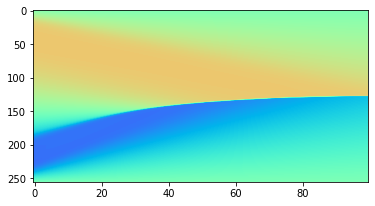

In [15]:
u_pred = PINN.test(X_u_test_tensor)

cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_pred.reshape(100,256)),cmap = cmap,aspect = 0.2,vmin=-10,vmax=10)

In [13]:
np.min(u_pred)

-7.1225796

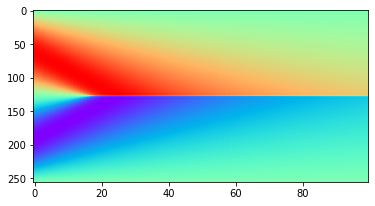

In [14]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(u_true.reshape(100,256)),cmap = cmap,aspect = 0.2,vmin=-10,vmax=10)

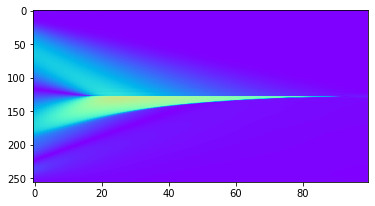

In [16]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(np.abs(u_pred - u_true).reshape(100,256)),cmap = cmap,aspect = 0.2,vmin=0,vmax=20)

In [10]:
a = 0 
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)

7.027523394560718


IndexError: list index out of range